# Proyek Klasifikasi Gambar: Corn or Maize Leaf Disease Dataset
- **Nama:** Muhammad Rofi'ul Arham
- **Email:** mc156d5y1107@student.devacademy.id // muhammadrofi062@gmail.com
- **ID Dicoding:** MC156D5Y1107 // muhammad_rofiul

## Import Semua Packages/Library yang Digunakan

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import splitfolders

## Data Preparation

### Data Loading

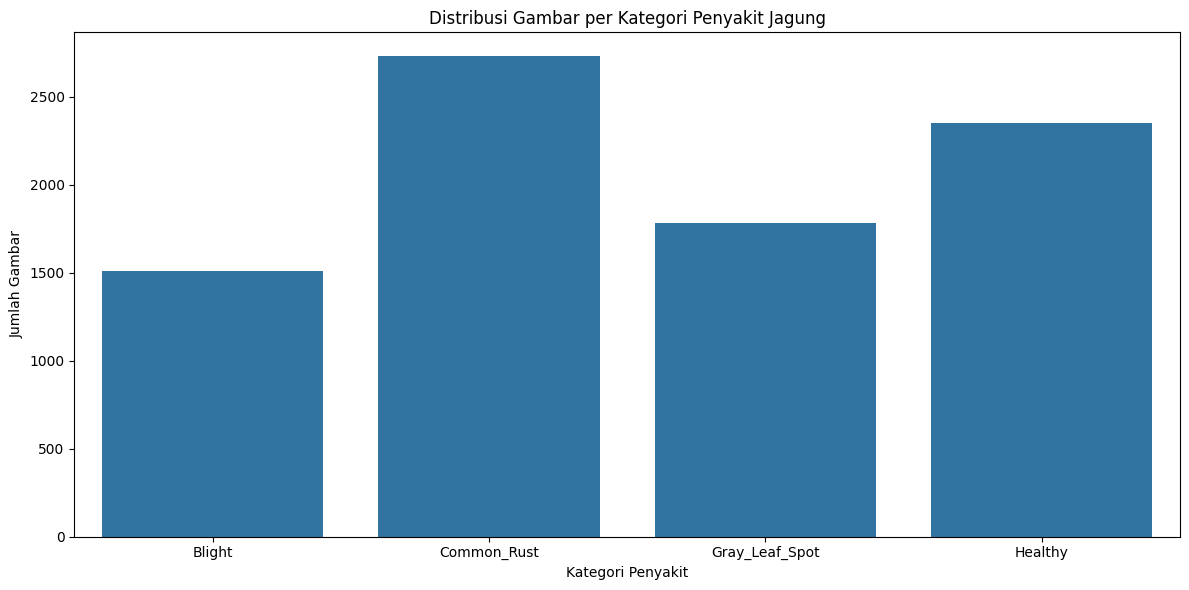

Total jumlah gambar: 8375
Blight: 1509 gambar (18.0%)
Common_Rust: 2729 gambar (32.6%)
Gray_Leaf_Spot: 1784 gambar (21.3%)
Healthy: 2353 gambar (28.1%)


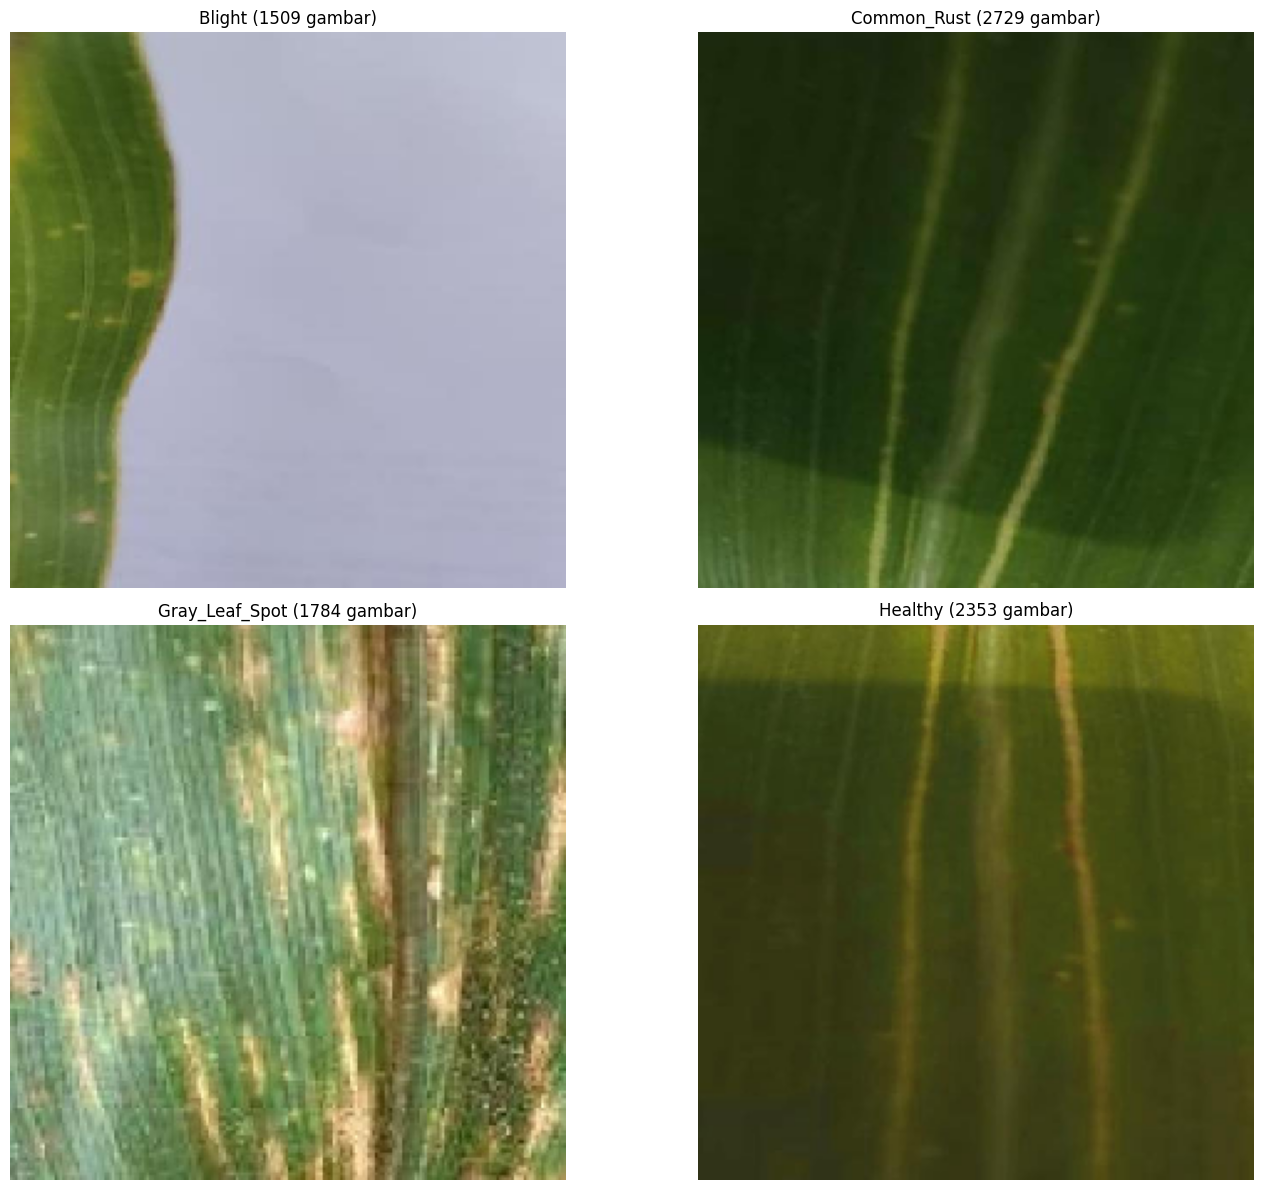

I0000 00:00:1745683237.257907   22153 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2249 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


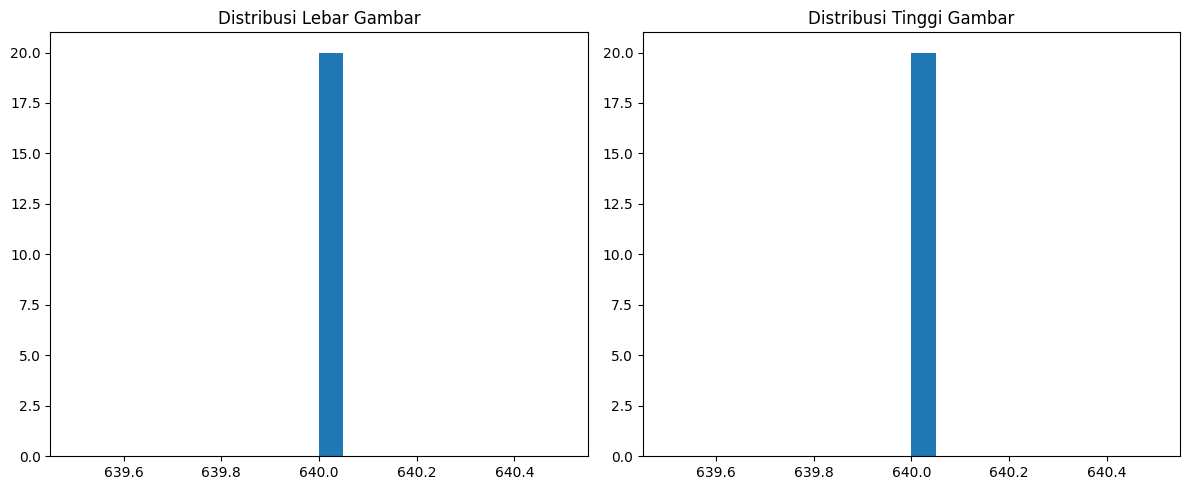

Rata-rata dimensi gambar: 640.0 x 640.0 pixel


In [2]:
# Define paths
dataset_path = "data/corn"
categories = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# Menghitung jumlah gambar per kategori
counts = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.exists(category_path):
        counts[category] = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
    else:
        counts[category] = 0

# Visualisasi distribusi data
plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title('Distribusi Gambar per Kategori Penyakit Jagung')
plt.ylabel('Jumlah Gambar')
plt.xlabel('Kategori Penyakit')
plt.tight_layout()
plt.show()

# Menampilkan informasi dataset
print("Total jumlah gambar:", sum(counts.values()))
for category, count in counts.items():
    print(f"{category}: {count} gambar ({count/sum(counts.values())*100:.1f}%)")

# Menampilkan contoh gambar dari setiap kategori
plt.figure(figsize=(15, 12))
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    if os.path.exists(category_path):
        img_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        if img_files:
            img_path = os.path.join(category_path, img_files[0])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            plt.subplot(2, 2, i+1)
            plt.imshow(img)
            plt.title(f"{category} ({counts[category]} gambar)")
            plt.axis('off')
plt.tight_layout()
plt.show()

# Memeriksa ukuran gambar
image_sizes = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.exists(category_path):
        img_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))][:5]  # Cek 5 gambar per kategori
        for img_file in img_files:
            img_path = os.path.join(category_path, img_file)
            with tf.io.gfile.GFile(img_path, 'rb') as img_file:
                img = tf.image.decode_image(img_file.read())
                height, width = img.shape[0], img.shape[1]
                image_sizes.append((width, height))

# Visualisasi distribusi ukuran gambar
if image_sizes:
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title('Distribusi Lebar Gambar')
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title('Distribusi Tinggi Gambar')
    plt.tight_layout()
    plt.show()
    
    # Print average image dimensions
    print(f"Rata-rata dimensi gambar: {sum(widths)/len(widths):.1f} x {sum(heights)/len(heights):.1f} pixel")

### Data Preprocessing

#### Split Dataset

In [3]:
# Mengumpulkan path gambar dan label
image_paths = []
labels = []

for category_idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for img_file in os.listdir(category_path):
        if img_file.endswith(('jpg', 'jpeg', 'png')):
            img_path = os.path.join(category_path, img_file)
            image_paths.append(img_path)
            labels.append(category_idx)

# Konversi ke array numpy
image_paths = np.array(image_paths)
labels = np.array(labels)

# Membagi dataset menjadi train (70%), validation (15%), dan test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, stratify=y_train_val, random_state=42
)

print(f"Train set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Train set: 4652 images
Validation set: 994 images
Test set: 997 images


In [4]:
# Ukuran gambar untuk model
IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=0.3,
    fill_mode='nearest'
)

# Hanya rescaling untuk validation dan test set
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Fungsi untuk memuat gambar dari path
def load_and_preprocess_from_path_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0  # Normalisasi [0,1]
    return img, label

# Membuat dataset TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_from_path_label)
train_ds = train_ds.shuffle(buffer_size=2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_from_path_label)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_from_path_label)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Modelling

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Membuat model Sequential
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Hitung class weights berdasarkan y_train
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


/mnt/c/Users/M. Rofi'ul Arham/Documents/Tugas/MBKM/DBS/klasifikasi gambar/submission/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: np.float64(1.1560636182902584), 1: np.float64(1.0808550185873607), 2: np.float64(1.24119530416222), 3: np.float64(0.7121861604409063)}


In [6]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# Training model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
    
)


Epoch 1/50


I0000 00:00:1745683294.617291   22591 service.cc:152] XLA service 0x7f93e0005aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745683294.617403   22591 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-26 23:01:35.078424: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745683295.727040   22591 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-26 23:01:39.196106: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng20{k2=2,k4=1,k5=0,k6=0,k7=0,k19=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.4718, f32[32,3,3,3]{3,2,1,0} %bitcast.4725, f32[32]{0} %bitcast.5302), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiva

  2/146 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.3828 - loss: 1.3440 

I0000 00:00:1745683305.644835   22591 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4644 - loss: 1.2211

2025-04-26 23:01:56.428694: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[12,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,224,224]{3,2,1,0} %bitcast.4718, f32[32,3,3,3]{3,2,1,0} %bitcast.4725, f32[32]{0} %bitcast.5302), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/mnt/c/Users/M. Rofi\'ul Arham/Documents/Tugas/MBKM/DBS/klasifikasi gambar/submission/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-26 23:01:56.499767: I external/local_xla/xla/servic

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4650 - loss: 1.2203

2025-04-26 23:02:01.133496: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.526, f32[32,3,3,3]{3,2,1,0} %bitcast.533, f32[32]{0} %bitcast.535), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/mnt/c/Users/M. Rofi\'ul Arham/Documents/Tugas/MBKM/DBS/klasifikasi gambar/submission/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-26 23:02:01.258991: I external/local_xla/xla/service/g

146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.4655 - loss: 1.2196 - val_accuracy: 0.6761 - val_loss: 0.8580 - learning_rate: 1.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.6461 - loss: 0.9244 - val_accuracy: 0.7173 - val_loss: 0.8489 - learning_rate: 1.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6983 - loss: 0.8510 - val_accuracy: 0.7304 - val_loss: 0.7616 - learning_rate: 1.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.7318 - loss: 0.7598 - val_accuracy: 0.7656 - val_loss: 0.6292 - learning_rate: 1.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.7571 - loss: 0.7085 - val_accuracy: 0.7767 - val_loss: 0.6375 - learning_rate: 1.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.7670 - loss: 0.6637 - val_accuracy: 0.8129 - val_loss: 0.5622 - learning_rate: 1.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accu

## Evaluasi dan Visualisasi

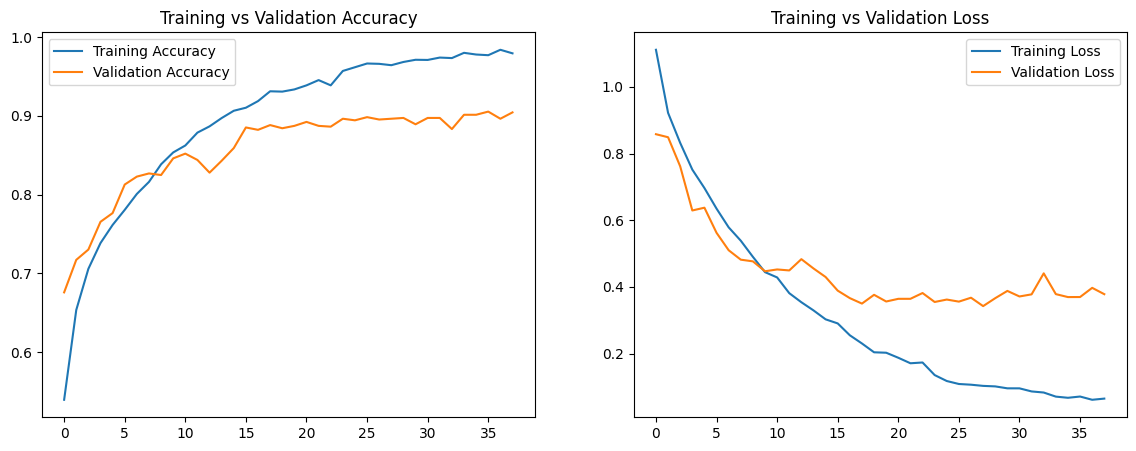

In [7]:
# Plot akurasi dan loss
plt.figure(figsize=(14,5))

# Akurasi
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9034 - loss: 0.3572

2025-04-26 23:11:25.800564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.9 = (f32[5,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,224,224]{3,2,1,0} %bitcast.526, f32[32,3,3,3]{3,2,1,0} %bitcast.533, f32[32]{0} %bitcast.535), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/mnt/c/Users/M. Rofi\'ul Arham/Documents/Tugas/MBKM/DBS/klasifikasi gambar/submission/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-26 23:11:25.928365: I external/local_xla/xla/service/gpu

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9031 - loss: 0.3562
Test Accuracy: 89.87%


2025-04-26 23:11:27.154712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


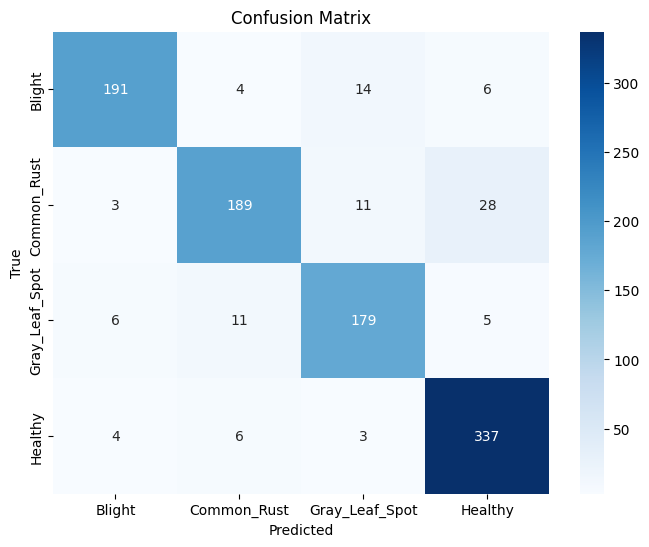

                precision    recall  f1-score   support

        Blight       0.94      0.89      0.91       215
   Common_Rust       0.90      0.82      0.86       231
Gray_Leaf_Spot       0.86      0.89      0.88       201
       Healthy       0.90      0.96      0.93       350

      accuracy                           0.90       997
     macro avg       0.90      0.89      0.89       997
  weighted avg       0.90      0.90      0.90       997



In [8]:
# Evaluasi di test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Confusion Matrix
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))


#### Performa Model & Analisis

 - **Akurasi**: 90%  
- **Precision Rata-rata**: 90%  
- **Recall Rata-rata**: 89%  
- **F1-Score Rata-rata**: 89%  

Berdasarkan hasil evaluasi, model klasifikasi menunjukkan kinerja yang baik dengan akurasi sebesar 90%. Nilai precision rata-rata sebesar 90% mengindikasikan bahwa sebagian besar prediksi positif yang dibuat oleh model adalah benar. Recall rata-rata sebesar 89% menunjukkan bahwa model mampu mengidentifikasi sebagian besar sampel yang relevan dengan benar. Selain itu, f1-score rata-rata sebesar 89% menunjukkan keseimbangan yang baik antara precision dan recall. Kesalahan klasifikasi terbanyak terjadi antara kelas Common Rust dan Healthy, serta antara Blight dan Gray Leaf Spot. Secara umum, tingkat kesalahan tergolong rendah dan tersebar merata, sehingga model dinilai cukup andal dalam membedakan keempat kelas yang ada.

## Konversi Model

In [ ]:
import tensorflowjs as tfjs

# SavedModel format
model.export("saved_model") 

# Save as TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Create label.txt
with open("tflite/label.txt", "w") as f:
    for label in categories:
        f.write(label + "\n")

# TensorFlowJS format
tfjs.converters.convert_tf_saved_model("saved_model", "tfjs_model")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140277436464496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140278442171152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140278441487952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277480594368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277480603344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277480590144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277480596480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277435679488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277435689344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140277435694448: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1745685542.821521   22153 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745685542.821565   22153 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-26 23:39:02.833571: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-26 23:39:02.836794: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-26 23:39:02.836829: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: saved_model
I0000 00:00:1745685542.857492   22153 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-26 23:39:02.858270: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-26 23:39:03.241181: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: saved_model
2025-04-26 23:39:03.248898: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags {

## Inference (Optional)

In [5]:
from tensorflow.keras.preprocessing import image

# 1. Load TFLite model
interpreter = tf.lite.Interpreter(
    model_path='tflite/model.tflite'
)
interpreter.allocate_tensors()

# 2. Load image
IMG_SIZE = 224  # Ukuran gambar sesuai training
img_path = 'data/DataTest/example_corn.jpg'

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalisasi ke [0,1]

# 3. Set input tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)

# 4. Run inference
interpreter.invoke()

# 5. Get prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

# 6. Daftar kelas
class_names = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

# 7. Print hasil
predicted_class_name = class_names[predicted_class]
confidence = np.max(output_data)

print(f"Predicted Class: {predicted_class_name} ({confidence*100:.2f}%)")

Predicted Class: Common_Rust (98.54%)
